<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">



# Week 9 - Word Embeddings

Word embeddings is a very popular an effective manner of giving ML models a sort of background knowledge of the vocabulary of a given document corpus. 

A word embedding is effectively, just a learned vector representation for text. The vectors can be in any number of arbitrary dimensions $m$, but the rule of thumb is often, that larger vocabularies and more intricate patterns, require more dimensions. Often, (and in this case) the goal is to have the vector representations model words semantic meanings, so words with similar meaning in texts, have similar representations. An example could be the words "cat" and "mouse" having a small difference between them, when compared to a word such as "prestidigitation".

Two things in particular are cool about word embeddings:

1. They can be used for downstream tasks; if you make a set of word embeddings using one dataset, they can most likely be used for other NLP applications, not even relevant to the original dataset on which the embeddings were trained.
2. They often "naturally" appear in neural networks. The first few layers often create useful representations of words so that similar words have similar representations. This means, these initial neural network layers can be extracted for other downstream applications, something which [Skipgram and CBOW](https://medium.com/@RobuRishabh/learning-word-embeddings-with-cbow-and-skip-gram-b834bde18de4) models leverage.

---

**At the end of this week, you should be able to:**

- Explain what word embeddings are
- Explain what a word co-occurence matrix is
- Know how to compare words using cosine similarities
- Explain hoa  GloVe word-embedding matrix looks roughly
- Explain how word embedding vectors relate to one another for related words.
- Reflect on how word embeddings can transmit societal bias 


---

## GloVE

[GloVe: Gloval Vectors for Word Representations](https://nlp.stanford.edu/projects/glove/) is an unsupervised learning method to obtain vector representations for words. [The paper is available here](https://nlp.stanford.edu/pubs/glove.pdf). The group out of Stanford, have released numerous different models, we will work with one trained on Wikipedia 2014, which contains $400000$ words, each represented by a feature vector with a dimensionality of $50$. You can download the full vector dataset here: [http://nlp.stanford.edu/data/glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip)

GloVe wasn't the first word embedding model, and today, is probably not even the best. What was unique about them, was the way they mixed *local* and *global* representations.

With bag-of-words and LSA in week 7, for example, we only achived a global representation, words related if they were in the same document, no matter how far apart they were. In Skipgram and CBOW (as fasttext uses), only local contexts matter. Whether words share a document does not matter, so long as they do not share a local context. GloVe, via "dark magic mathematics" (not necessary to learn in-depth), mixes both of these. Moreover, they constrain their embeddings to have linear relationships between a lot of the words:

<div style="text-align: center">
  <img src="images/linear_relationships.png" alt="Centered Image"/>
</div>

Meaning, simple additive or multiplicative operations should bring you somewhat closer to another word. To achieve this, they among other things, eschew the use of Neural networks to create the embeddings, as they are by design, nonlinaer. Meaning, even if they led to better embeddings, the relationship between different embeddings, could be decidedly nonlinear, and difficult to interpret by humans.

</span>

In [2]:
import re
import numpy as np
import pandas as pd

from scipy import spatial
from scipy.linalg import eigh
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict, Counter

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 0 - The expected preprocessing step

The first thing we wanna do to help the understanding of what GloVe does, is make a co-occurence matrix. You'll remember similar from week 8, which is simply where we check how often words appear in each other's contexts.

#### **1.1. Briefly inspect the `preprocess_text` function below, and list what it does:**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

1. Strips out extra spaces
2. Sets all text to lower
3. Removes all special characters
4. Splits text by new lines
5. Removes headlines
6. Recreates full document
7. Removes end lines

</span>


</span>

In [3]:
def preprocess_text(text):
    text = text.strip()
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9?! \n]+", "", text)
    text = text.split("\n")
    text = [line.strip() for line in text if line.find("chapter") == -1]
    text = "\n".join(text)
    text = text.replace("\n", " ").replace("  ", " ")
    return text

In [4]:
# Load the data
data = pd.read_csv("data/Reviews.csv")
reviews = data["Text"].values[:4] # take only first couple of reviews

# Clean the data using our function above
reviews_clean = [preprocess_text(review) for review in reviews]

# Split each word in lists
words_in_review = []
for review in reviews_clean:
    words_in_review.extend(review.split())
print(words_in_review)

['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most', 'product', 'arrived', 'labeled', 'as', 'jumbo', 'salted', 'peanutsthe', 'peanuts', 'were', 'actually', 'small', 'sized', 'unsalted', 'not', 'sure', 'if', 'this', 'was', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intended', 'to', 'represent', 'the', 'product', 'as', 'jumbo', 'this', 'is', 'a', 'confection', 'that', 'has', 'been', 'around', 'a', 'few', 'centuries', 'it', 'is', 'a', 'light', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', 'in', 'this', 'case', 'filberts', 'and', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'powdered', 'sugar',

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 1 - Co-occurrence matrix

The first thing we wanna do to help the understanding of what GloVe does, is make a co-occurence matrix. You'll remember similar from week 8, which is simply where we check how often words appear in each other's contexts.


#### **1.1 Look at the `calculate_co_occurence` function, and get a feel for how it works, see if you can locate all the given steps:**

1. Initialise a default dictionary with the Counter object
2. Iterate across each review and then enumerate across words in that review
3. Calculate at what index to start and stop counting words based $L$
    - Make sure you do not count the word itself
4. Increment the counter for the context of the word under consideration
    - `co_occurrence_counts[word][words[j]] += 1`
5. Convert the dictionary to a pandas dataframe
    - `pd.DataFrame(co_occurrence_counts).fillna(0)` does the job!
6. Sort the rows and columns by their respective indexes
    - `.sort_index(axis=0).sort_index(axis=1)`

#### **1.2 Run the code two cells below, the resulting plot should be how often words appear in each other's contexts. Describe if anything stands out.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It is extremely *sparse*. Most of the indices are 0, since most words never appear in each other's contexts. This is one of the challenges of NLP, and why it often requires working with sparse matrices, where most indices are close to or exactly 0.

</span>


</span>


In [5]:
def calculate_co_occurence(texts, L_front, L_end=None):
    """_summary_

    Args:
        text (_type_): The text to calculate the co-occurence matrix of
        L_front (int): Number of words before to consider
        L_end (int), optional): Number of words after a word to consider, if None is the same as L_front
    """
    if L_end is None:
        L_end = L_front
    
    # Initialize an empty dictionary for co-occurrence counts
    # collections.Counter in this case, is a more 'powerful' alternative to defaultdict(lambda: 0)
    co_occurrence_counts = defaultdict(Counter)

    # Build co-occurrence counts based on reviews
    for text in texts:
        words = text.lower().split()
        for i, word in enumerate(words):
            # Look L words before and after the current word
            start = max(0, i - L_front)
            end = min(len(words), i + L_end + 1)
            for j in range(start, end):
                if i != j:
                    co_occurrence_counts[word][words[j]] += 1

    # Convert to DataFrame for better readability
    X_ij = pd.DataFrame(co_occurrence_counts).fillna(0)
    X_ij = X_ij.sort_index(axis=0).sort_index(axis=1)
    return X_ij

Plot $X$ as an image

          "jumbo".  "the  (which    -    a  actually  addition  all   an  and  \
"jumbo".       0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   
"the           0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   
(which         0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   
-              0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   
a              0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   
...            ...   ...     ...  ...  ...       ...       ...  ...  ...  ...   
witch,         0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  1.0   
witch.         0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   
with           0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   
you            0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   
yummy          0.0   0.0     0.0  0.0  0.0       0.0       0.0  0.0  0.0  0.0   

          ...  very  vitali

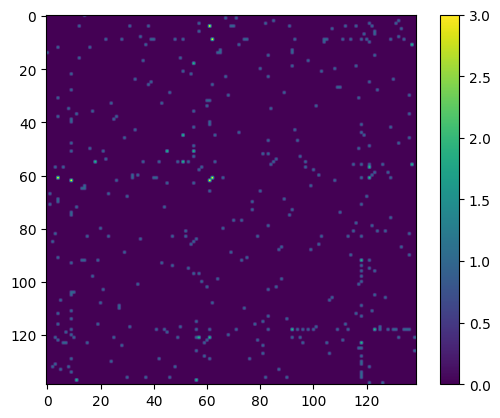

In [6]:
X_ij = calculate_co_occurence(reviews, 1)
print(X_ij)

plt.imshow(X_ij.to_numpy())
plt.colorbar()
plt.show()

# Exercise 2 Load Glove Vectors 



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 2 - Loading GloVe vectors 

The Glove vectors we are going to use are located in a text file, where each line describes one word and its associated feature vector. Formatted as such: `word float float float ...`

#### **💻 2.1 Implement the `load_glove_vectors` function below, it should:**

1. Open the file a given glove file
2. Iterate across each line
3. Split the line into the word and the vector
    - Numpy's `np.asarray()` function can take a string containing numbers and put them in an array
4. Insert the word as a key in the dictionary and the vector as the value


#### **2.2 If we represented the GlOVe dictionary as one big matrix, what would its dimensionality be, and what would this mean?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It would be $400000\times 50. The number of words times the dimensionality of each word-vector$

</span>




In [28]:
def load_glove_vectors(glove_file_path):
    """

    """
    glove_dictionary = {}
    with open(glove_file_path,'r', encoding='utf-8') as file:
        for line in tqdm(file):
            elements = line.split()
            word = elements[0]
            vector = np.asarray(elements[1:],"float32")
            glove_dictionary[word] = vector
    
    return glove_dictionary

In [29]:
filename = "glove.6B.50d.txt"
glove_dictionary = load_glove_vectors(filename)

print(len(glove_dictionary), glove_dictionary["have"].shape)

400000it [00:03, 113343.70it/s]

400000 (50,)


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 3 - Word similarities

In this exercise you will inspect the word embedding for different words, in order to determine whether words that semantically have similar meaning (or are semantically related) also have similar representations under the embedding.

To compare two words, we use the cosine similarity score between the feature vectors representing the two words.

#### **💻 3.1. Implement a function `cos_sim`, which computes the cosine similarity of two vectors: $\text{cosine\_similarity} = 1 - \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \|\vec{B}\|}$**

#### **💻 3.2 Implement the function `word_similarity`, which computes the similarity of two words as strings.**

#### **3.3 Run the cells after two steps below, and compare the simliarity scores for each word pair within each group. You can use the following questions as guide for your answer:**

- Do the relative differences in scores reflect your own intuition? 
- Does this inform you about certain relations captured by the word embedding? 
- For instance, what can you learn from observing that 'Denmark' is more similar to 'Sweden' than to 'Copenhagen'?


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Kinda, my intuition with words isn't really that good, but sometimes teh similarity may be a bit off. Why is brother and son so similar? Why is it more similar than daughter and sister?

Likewise, with prepositions, it may seem a bit arbritrary that left and right recieve less similarity than vertical and horizontal, though in this case, it may have to do with the fact that 'left' and 'right' is also used in politics or non-preposition related meanings.

Overall, we can go two ways; either try to make sense of it from a language perspective, or just accept that sometimes ML does weird things.

</span>

#### **3.4 What would be the similarity between the words "cat" and "cat"?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

1 - they're the same word, duh

</span>

</span>

In [9]:
def cos_sim(v1, v2):
    return 1 - spatial.distance.cosine(v1,v2)

def word_similarity(word1, word2, verbose=True):    
    v1 = glove_dictionary[word1]
    v2 = glove_dictionary[word2]
    similarity =  cos_sim(v1,v2)
    if verbose:
        print(f"Similarity score between {word1} and {word2} = {similarity:.3f}") 
    return similarity

In [10]:
#humans and family structures
word_similarity("king","queen")
word_similarity("prince","princess")
word_similarity("prince","brother")
word_similarity("princess","sister")
word_similarity("prince","sister")
word_similarity("princess","brother")
word_similarity("brother","sister")
word_similarity("brother","son")
word_similarity("sister","daughter")
word_similarity("brother","daughter")
word_similarity("sister","son")

Similarity score between king and queen = 0.784
Similarity score between prince and princess = 0.743
Similarity score between prince and brother = 0.759
Similarity score between princess and sister = 0.764
Similarity score between prince and sister = 0.591
Similarity score between princess and brother = 0.527
Similarity score between brother and sister = 0.725
Similarity score between brother and son = 0.945
Similarity score between sister and daughter = 0.893
Similarity score between brother and daughter = 0.827
Similarity score between sister and son = 0.750


0.750402304843057

In [11]:
#prepositions and orientations
word_similarity("after","before")
word_similarity("over","under")
word_similarity("vertical","horizontal")
word_similarity("left","right")

Similarity score between after and before = 0.951
Similarity score between over and under = 0.754
Similarity score between vertical and horizontal = 0.956
Similarity score between left and right = 0.781


0.781184383748652

In [12]:
#toponyms (places)
word_similarity("city","country")
word_similarity("city","town")
word_similarity("denmark","sweden")
word_similarity("denmark","copenhagen")
word_similarity("stockholm","copenhagen")
word_similarity("stockholm","denmark")
word_similarity("sweden","stockholm")
word_similarity("sweden","copenhagen")
word_similarity("walk","run")
word_similarity("run","sit")
word_similarity("walk","sit")

Similarity score between city and country = 0.667
Similarity score between city and town = 0.869
Similarity score between denmark and sweden = 0.885
Similarity score between denmark and copenhagen = 0.631
Similarity score between stockholm and copenhagen = 0.763
Similarity score between stockholm and denmark = 0.579
Similarity score between sweden and stockholm = 0.698
Similarity score between sweden and copenhagen = 0.573
Similarity score between walk and run = 0.683
Similarity score between run and sit = 0.539
Similarity score between walk and sit = 0.759


0.7587370613751933

In [13]:
#Homonyms (words with different meanings)
word_similarity("second","minute")
word_similarity("first","second")
word_similarity("first","minute")

Similarity score between second and minute = 0.720
Similarity score between first and second = 0.932
Similarity score between first and minute = 0.596


0.5956816559051554

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 4: Nearest Neighbours

It can be pretty useful to find the $N$ nearest neighbours to a word, given the glove embedding.

#### **💻 4.1 Implement the function `nearest_neighbours` which computes the $N$ nearest neighbours (most similar words) to a single word. You can follow the steps as outlined below:**

1. Create an array containing all the vectors representations of every word and one for the vectors
         - `.keys()` provides an iterable of the keys of a dictionary
         - `.values()` does the same for the values, in the same order 
2. Compute the similarity scores using the dot product between the vector of the word and all the words in the vocabulary
3. Find the top indices 

#### **4.2 Look at the various words two steps below, do you agree that they are similar?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

I mean, I'm kinda chuffed that Sweden is more like Denmark than Norway, but otherwise, makes sense. You can also debate whether prince or queen is most similar, interesting to see whether gender or position is valued most, but that is a whole can of worms in ML

</span>

#### **4.3 Try to come up with some words that are dissimilar from any other What do you find?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

I thought I had a winner with "prestidigitation", but "high-brow" and "grandiloquence" are close to it, probably because, they like prestidigitation, are never really used. Grandiloquence especially means "pompous or extravagent langauge", which pretty well describes the kind of people who would seriously use prestidigitation (apart from D&D players). Overall, this is an example of not the meaning of the word, but when the word is used, being more relevant.

</span>

</span>

The word itself
- Look at various words and comment on the similar words. Do you agree that they are similar?

In [30]:
def nearest_neighbours(word, num_neighbours):    
    words = np.array(list(glove_dictionary.keys()))
    vectors = np.array(list(glove_dictionary.values()))
    
    # Compute cosine similarity between the target word vector and all vectors
    v = glove_dictionary[word]
    scores = np.dot(vectors, v) / (np.linalg.norm(vectors, axis=1) * np.linalg.norm(v))
    
    # Get indices of the top scores
    top_indices = np.argsort(scores)[-num_neighbours:][::-1]
    
    # Print the most similar words with their similarity scores
    print(f"Most similar words to '{word}':")
    for idx in top_indices:
        print(f"{scores[idx]:.4f}\t{words[idx]}")  

In [32]:
nearest_neighbours("prestidigitation", 3)
nearest_neighbours("king", 3)

Most similar words to 'prestidigitation':
1.0000	prestidigitation
0.7949	high-brow
0.7878	grandiloquence
Most similar words to 'king':
1.0000	king
0.8236	prince
0.7839	queen


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 5 - Visualizing words using PCA

In this exercise we use principal component analysis (PCA) to reduce the dimensionality of the feature vector space. This allows us to illustrate the spatial relation between different words from the vocabulary.

#### **5.1. 💻 Implement the function, `plot_pca` that conducts PCA on a sub-set of the data and projects these data-points onto the first two principal components. You can follow these steps:** 
- Follow these steps:
    1. Obtain a matrix of the vectors and transpose it
    2. Subtract the mean of each dimension (axis=1) from the matrix
    3. Compute the eigenvectors and values of the covariance matrix
    4. Project the data onto the eigenvectors. Pay attention to the dimensions in order to do the projection correctly
    5. The eigenvectors are initially sorted in ascending order, take use the dimensions corresponding to the largest eigenvalues and plot them

#### **5.2 Comment on any linearity and distance between pairs of words.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Not much to say, than they are linear, words that are similar have a linear relationship between them, at least in these two dimensions.

</span>

#### **5.3 When visualizing for many words, comment on which words are grouped together. Does the grouping capture any semantic meaning?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Pretty much what has been mentioned before, but those with large similarity are grouped together.

Worth noting, is perhaps the distance may also mean something, meaning that the choice of cosine similarity may not be entirely cognisant, as it only takes into account angle between vectors.

</span>

In [16]:
def plot_pca(word_list):
    #obtain dictionary of words from word_list
    vectors = np.asarray([glove_dictionary[key] for key in word_list]).T
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    #compute the covariance matrix
    S = np.cov(data)
    #obtain eigenvectors and eigenvalues
    eigen_values, eigen_vectors = eigh(S)
    #sort according to size of eigenvalues
    Y = eigen_vectors.T @ (data)    # shape = (dim_vectors, num_words)
    #plot for first two principal components
    for label, x, y in zip(word_list, Y[-1,:], Y[-2,:]):
        plt.plot(x,y,"*")
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

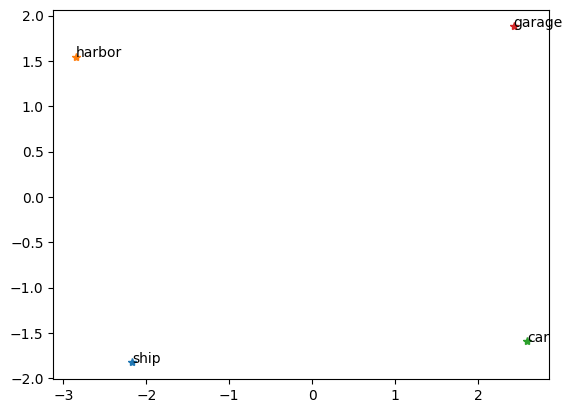

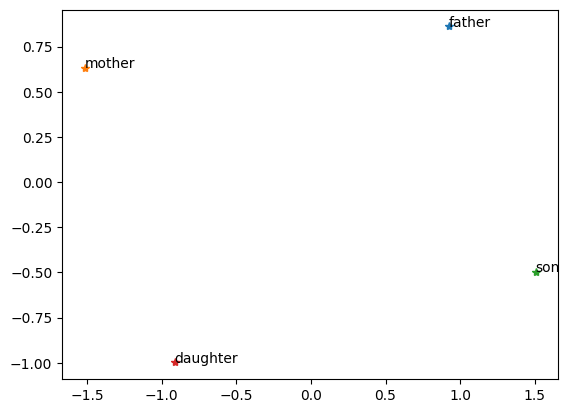

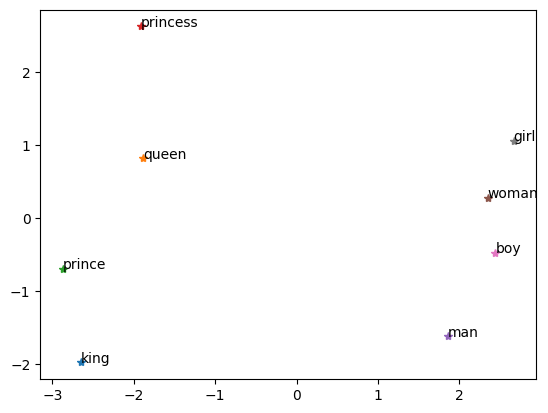

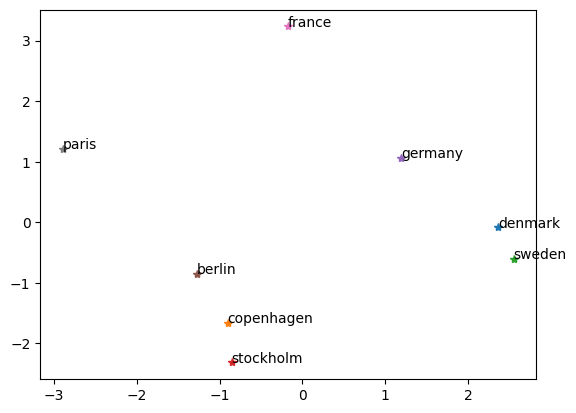

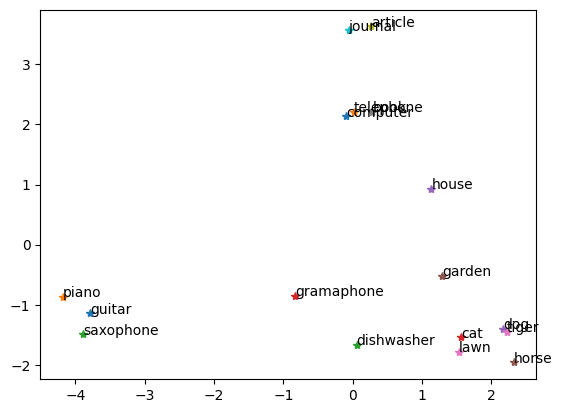

In [17]:
plot_pca(["ship","harbor","car","garage"])
plot_pca(["father","mother","son","daughter"])
plot_pca(["king","queen","prince","princess","man","woman","boy","girl"])
plot_pca(["denmark","copenhagen","sweden","stockholm","germany","berlin","france","paris"])
plot_pca(["guitar","piano","saxophone","cat","dog","horse","tiger","book","article","journal","computer","telephone","dishwasher","gramaphone","house","garden","lawn"])

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 6 - Solving analogies
As defined by Aristotle as "an equality of proportions", an analogy can be considered a problem involving four terms, such that the second term is related to the first in a similar way as the forth term is related to the third.

An example of an analogy is;
- *evening* is to *morning* as *dinner* is to *breakfast*

Analogies are often used as verbal reasoning tests, where the test subject is asked to infer the similarity between two relations, by only being presented the first three terms of the analogy problem.
For instance, the subject is expected to infer the term *girl* from the problem;
- *brother* is to *sister* as *boy* is to *???*

These kind of problems are often included in assessments of intelligence (such as IQ or children development tests) as the ability to draw analogies are believed to reflect the underlying cognitive ability to represent and reason about higher-order relations.

In this exercise you are going to examine an AI algorithm for solving such analogy problems. As input, the algorithm is given the first three terms of an analogy problem. It will then rely on the linear substructure of the GloVe word embedding to find and return the best candidate word for the forth term.

**Algorithm:**
For a given problem, let $v_1,v_2,v_3$ be the vector representations for the first three terms. 
The guess for the forth term is found as the word for which the associated vector representation is most similar to the vector $v_d = (v_3 - (v_1-v_2))$. To compare vectors, the algorithm uses the cosine similarity measure.

#### **6.1. Argue why this approach is reasonable and why $v_d$ is computed as it is**

*Hint: It may be easier to build intuition from considering the problem in 2D.*

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It's mostly smoke and mirrors, it can be rewritten as $v_d = v_3 + (v_2 - v_1)$, which is exactly our "king - man + woman = queen" question, which is what we really want to find. The rest of it is just cosine similarity, which we have done ad nauseam before.

</span>

#### **💻 6.2 Implement the function `find_analogy`, you can follow the following steps:**

- Follow these steps:
    1. Get the vector representations for each of the 3 words and calculate the fourth vector
    2. Create a matrix of word vectors that excludes the three original words 
    3. Calculate the distances to $v_d$
        - For this, implement a cos_sim function that calculates the cosine similarity between a vector and a matrix `cos_sim_vec_mat`
    4. Return the `N` closest words and their scores
        - `np.argsort` sorts a vector in ascending order, `[::-1]` can be used to reverse the order of an array
        - To use the indexes on a list it must be converted to a numpy array

#### **6.3 Test the algorithm with the provided examples as well as with analogy problems of your own. Investigate whether there are particular types of analogies that the algorithm cannot solve. Comment on why this is.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **💻 6.4 For real cognitive tests the analogy problem is often presented as a multiple-choice question. Implement the function `find_analogy_multiple_choice` to present such a setting. Before you start, think on whether you would expect it to perform better or worse, and test it afterwards. The changes that need to be make programatically, are:**

 1. The function must take a list of words from which to choose 
 2. These must be used to create the matrix for calculating the similarities

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


In [ ]:
def cos_sim_vec_mat(v1, v2):
    """Compute cosine similarity between a vector and a matrix."""
    # Normalize the vector v1
    v1_norm = v1 / np.linalg.norm(v1)

    # Normalize the matrix v2
    v2_norm = v2 / np.linalg.norm(v2, axis=1, keepdims=True)

    # Compute the cosine similarity
    similarity = np.dot(v2_norm, v1_norm)

    return similarity

def find_analogy(w1, w2, w3, N=1):
    # Retrieve vectors for the input words
    v1 = glove_dictionary[w1]
    v2 = glove_dictionary[w2]
    v3 = glove_dictionary[w3]
    
    # Calculate the analogy vector
    vd = v3 - (v1 - v2)
    
    # Create a list of words excluding w1, w2, w3
    words = list(glove_dictionary.keys())
    filtered_words = [word for word in words if word not in {w1, w2, w3}]
    
    # Get the vectors for the filtered words
    vectors = np.array([glove_dictionary[word] for word in filtered_words])
    find_analogy_multiple_choice
    # Calculate cosine similarities
    similarities = cos_sim_vec_mat(vd, vectors)
    
    # Find the index of the maximum similarity
    max_indexes = np.argsort(similarities)[-N:][::-1]
    
    # Return the corresponding word
    return np.array(filtered_words)[max_indexes], similarities[max_indexes]

man is to woman as doctor is to:
1: nurse: 0.842
2: child: 0.775
3: pregnant: 0.768
4: mother: 0.766
5: patient: 0.749


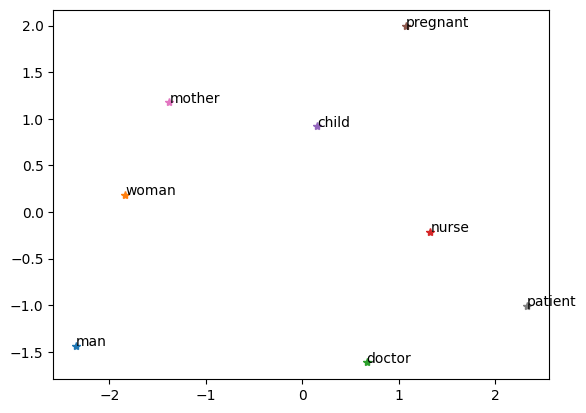

In [20]:
N = 5
#examples of analogy problems

#w1 = "man"; w2 = "woman"; w3 = "king";
#w1 = "brother"; w2 = "sister"; w3 = "boy";
#w1 = "pen"; w2 = "paper"; w3 = "doctor";
#w1 = "denmark"; w2 = "copenhagen"; w3 = "germany";
#w1 = "denmark"; w2 = "copenhagen"; w3 = "france";
#w1 = "denmark"; w2 = "france"; w3 = "copenhagen";
#w1 = "car"; w2 = "parking"; w3 = "ship";
#w1 = "left"; w2 = "right"; w3 = "horizontal";
#w1 = "woman"; w2 = "man"; w3 = "mother";
w1 = "man"; w2 = "woman"; w3 = "doctor";

w4, scores = find_analogy(w1, w2, w3, N)
print(w1, "is to", w2, "as", w3, "is to:")
for i, (word, score) in enumerate(zip(w4, scores)):
    print(f"{i+1}: {word}: {score:.3}")
plot_pca([w1,w2,w3,*w4])

In [21]:
def find_analogy_multiple_choice(w1, w2, w3, choices, N=1):
    # Retrieve vectors for the input words
    v1 = glove_dictionary[w1]
    v2 = glove_dictionary[w2]
    v3 = glove_dictionary[w3]
    
    # Calculate the analogy vector
    vd = v3 - (v1 - v2)
    # Get the vectors for the filtered words
    vectors = np.array([glove_dictionary[word] for word in choices])
    
    # Calculate cosine similarities
    similarities = cos_sim_vec_mat(vd, vectors)
    
    # Find the index of the maximum similarity
    max_indexes = np.argsort(similarities)[-N:][::-1]
    
    # Return the corresponding word
    return np.array(choices)[max_indexes], similarities[max_indexes]

man is to woman as doctor is to:
1: nurse: 0.842
2: teacher: 0.715
3: lawyer: 0.508
4: engineer: 0.415


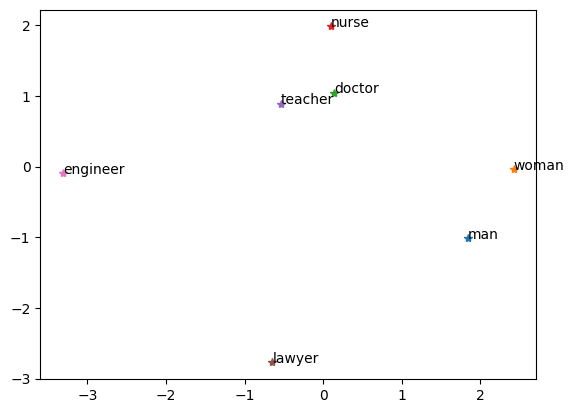

In [22]:
N = 4
# w1 = "man"; w2 = "woman"; w3 = "king"; options = ["queen", "prince", "father", "sister"]
# w1 = "brother"; w2 = "sister"; w3 = "boy"; options = ["girl", "man", "child", "parent"]
# w1 = "pen"; w2 = "paper"; w3 = "doctor"; options = ["stethoscope", "hospital", "patient", "nurse"]
# w1 = "denmark"; w2 = "copenhagen"; w3 = "germany"; options = ["berlin", "france", "sweden", "norway"]
# w1 = "denmark"; w2 = "copenhagen"; w3 = "france"; options = ["paris", "lyon", "marseille", "nice"]
# w1 = "denmark"; w2 = "france"; w3 = "copenhagen"; options = ["paris", "stockholm", "oslo", "helsinki"]
# w1 = "car"; w2 = "parking"; w3 = "ship"; options = ["dock", "garage", "boat", "plane"]
# w1 = "left"; w2 = "right"; w3 = "horizontal"; options = ["vertical", "diagonal", "up", "down"]
# w1 = "woman"; w2 = "man"; w3 = "mother"; options = ["father", "child", "sister", "parent"]
w1 = "man"; w2 = "woman"; w3 = "doctor"; options = ["nurse", "teacher", "engineer", "lawyer"]

w4, scores = find_analogy_multiple_choice(w1, w2, w3, choices=options, N=N)
print(w1, "is to", w2, "as", w3, "is to:")
for i, (word, score) in enumerate(zip(w4, scores)):
    print(f"{i+1}: {word}: {score:.3}")
plot_pca([w1,w2,w3,*w4])

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 7 - Quantifying stereotypes

As for most machine learning algorithms, word embedding can be proned to biases. If the original data contained systematic biases, the learned representations may also reflect these biases. The GloVe machine learning algorithm was trained on Wikipedia texts. If these texts in general contained or described specific stereotypes, the word embedding will also capture these stereotypes. 
Often it is found that word embeddings contain gender stereotypes, often significantly with regards to professions.

#### **7.1. In the above exercises we have used the plot_pca function to visualize the words "nurse", "doctor", "man" and "woman". Comment on the plots in terms of gender stereotypes.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **8.2 Compare the cosine distance between various professions ("programmer", "secretary", "pilot", "president", "nurse",...) and the words "mother" and "farther". Comment on your findings.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **8.3 Evaluate terms that relate to the two words "man" and "woman" by comparing the nearest neighbours to "man" and "woman" respectively. Are there any professions related to "man" and "woman"? Do "man" and "woman" have neighbours in common?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **8.4 Based on your findings, discuss whether you can use the analogy solver to test for various biases or stereotypes that may have been conveyed to the word embedding**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


#### **8.5. Reflect on whether word embedding in general is a feasible approach to verify if a text corpus contains biases or stereotypes.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>


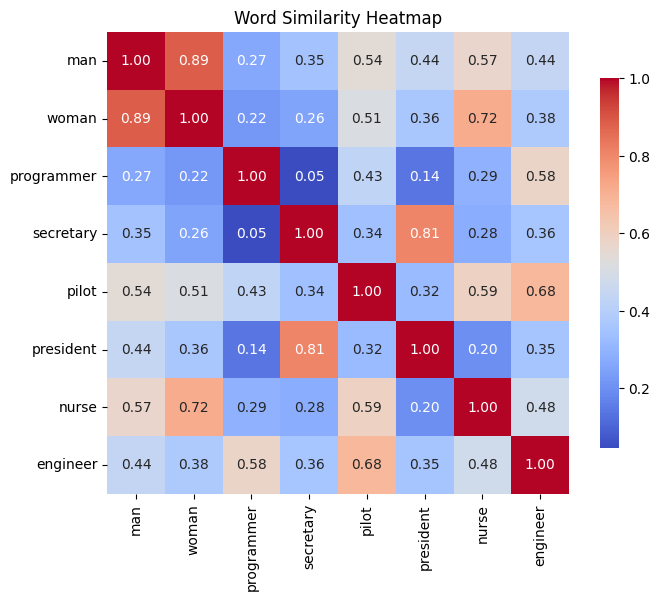

In [23]:
import seaborn as sns

# Define the words for which you want to compute similarities
words = ["man", "woman", "programmer", "secretary", "pilot", "president", "nurse", "engineer",]

# Create a similarity matrix
similarity_matrix = np.zeros((len(words), len(words)))

for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        similarity_matrix[i, j] = word_similarity(word1, word2, verbose=False)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Word Similarity Heatmap')
plt.show()

In [24]:
nearest_neighbours("woman", 15)

Most similar words to 'woman':
1.0000	woman
0.9065	girl
0.8860	man
0.8764	mother
0.8613	her
0.8596	boy
0.8431	she
0.8225	herself
0.8108	child
0.8037	wife
0.7982	old
0.7976	victim
0.7936	husband
0.7868	person
0.7832	grandmother


In [25]:
nearest_neighbours("man", 15)

Most similar words to 'man':
1.0000	man
0.8860	woman
0.8564	boy
0.8453	another
0.8372	old
0.8276	one
0.8245	who
0.8195	him
0.8154	turned
0.8120	whose
0.8077	himself
0.8053	his
0.8051	a
0.7960	friend
0.7957	she
